In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit

In [2]:
from traceTwoStateSimulation import tracePackageSimulation
from telegraph import exponential
from pol_signal import pol_signal
from loopFunction import SnailPromoterMs2Loops,loopInterpolate,tailUpMs2,DespondsMs2Loops
from autocorrelationDataProcessing import tracePackageAutocorrelation
from autocorrelationAnalyticInference import fitAutocorrelationFunction

In [152]:
# define all needed parameters for simulation and fitting #
stepsize = 3.8            # time between observations, seconds
tPol=6;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

k_on = 0.0013
k_off = 0.0030
duration = 3000   # seconds
num = 250           # number of traces in our simulated dataset

loop_function = SnailPromoterMs2Loops().loop_function

In [153]:
stepsize

3.8

In [154]:
# simulated trace package
tracePackage = tracePackageSimulation(num, k_on, k_off, duration, stepsize, loop_function, k_elong, tPol)

In [155]:
tracelist = tracePackage.tracelist
len(tracelist[1])

600

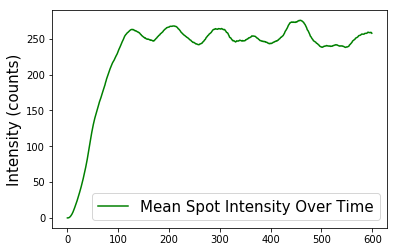

In [156]:
plt.plot(np.mean(tracelist, axis=0), color='g', label='Mean Spot Intensity Over Time')
plt.legend(loc='best', fontsize=15)
plt.ylabel('Intensity (counts)', fontsize=15)
plt.show()

In [157]:
# define start and stop indeces
start_index = 150
stop_index = -1

In [158]:
autopackage = tracePackageAutocorrelation(tracelist, loop_function, start_index, stop_index)

In [159]:
t = np.arange(len(autopackage.tracelist[1][1:]))

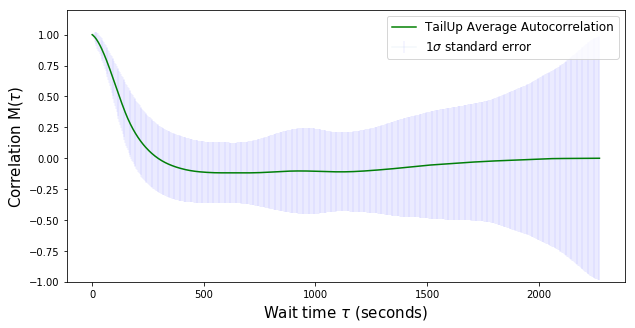

In [160]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
autoav = autopackage.autoav
autostd = autopackage.auto_err
avgflors = autopackage.avgflors

ax.plot(t*stepsize, autoav, color = 'g', label = "TailUp Average Autocorrelation")
ax.errorbar(x=t*stepsize, y=autoav, yerr=(autostd, autostd), ecolor='b', alpha=0.05, label = r'1$\sigma$ standard error')  
ax.legend(loc='best', fontsize='large')
ax.set_xlabel(r'Wait time $\tau$ (seconds)', fontsize=15)
ax.set_ylabel(r'Correlation M($\tau$)', fontsize=15)
ax.set_ylim(-1, 1.2)
plt.show()

In [161]:
fitAutoPack = fitAutocorrelationFunction(autopackage, tPol, k_elong, stepsize)

Pon                       =  0.2982998011240812
k_on + k_off              =  0.00787454480743004 s^-1
k_on                      =  0.0023489751499990476
k_off                     =  0.005525569657430993
t_polII_block             =  6 seconds
characteristic timescale  =  126.99146737427264 seconds
covariance                =  2.262546504226643e-08


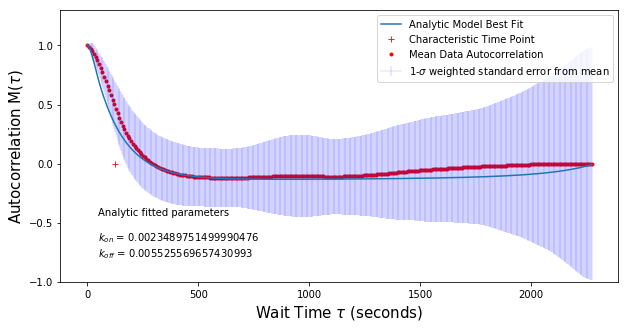

In [162]:
kon_fit,koff_fit,chrtime,pon,popt,pcov = fitAutoPack.leastSquaresAutoFit(printvals=True, 
                                                                                   upperbound=1/tPol, lowerbound=0.001,fitpon=True)

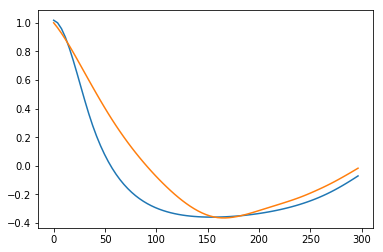

In [16]:
plt.plot(t*stepsize, fitAutoPack.autocorrFunc(t*stepsize, 1/34))
plt.plot(t*stepsize, autoav)

In [19]:
# something to plot with
t = np.arange(len(autoav))

In [19]:
np.linalg.eig(pcov)

(array([4.15360676e-07]), array([[1.]]))

In [16]:
# some tricks to get info we need to plot an ellipse, aligned with # some t 
#    the eigenvectors of the covariance matrix
eigval,eigvec = np.linalg.eig(pcov)
angle = np.degrees(np.arctan2(eigvec[0,0], eigvec[0,0]))
w = 2*np.sqrt(eigval)
h=0

In [17]:
w

array([0.00395696])

In [18]:
pars = [kon_fit,koff_fit]

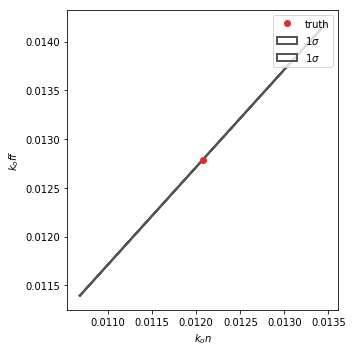

In [19]:
from  matplotlib.patches  import Ellipse

fig,ax = plt.subplots(1, 1, figsize=(5,5))

for n in [1,1]:
    ax.add_patch(Ellipse(pars, width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=3-n, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))

ax.plot(kon_fit, koff_fit, marker='o', zorder=10, linestyle='none',
        color='#de2d26', label='truth')

ax.set_xlabel('$k_on$')
ax.set_ylabel('$k_off$')
ax.legend(loc='best')

fig.tight_layout()

In [68]:
# Now create a loop to fit our MS2 Loop Construct to a range of parameters to test our inference.
# define all needed parameters for simulation and fitting #
stepsize = 3.8            # time between observations, seconds
tPol=4;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

kon_range = np.linspace(start=0.001, stop=0.08, num=10)
# keep kon constant for the time being
#k_on_range = np.ones(10) * 0.016
koff_range = np.linspace(start=0.02, stop=0.11, num=10)

ksum_true = np.linspace(start=0.001, stop=0.15, num=10)

duration = 500   # seconds
num = 200           # number of traces in each simulated dataset

pon = 0.1        # set pon to test inference

loop_function = SnailPromoterMs2Loops().loop_function


In [69]:
ksum_true

array([0.001     , 0.01755556, 0.03411111, 0.05066667, 0.06722222,
       0.08377778, 0.10033333, 0.11688889, 0.13344444, 0.15      ])

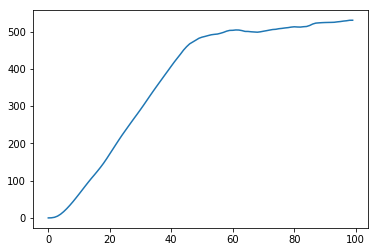

In [70]:
tracePackage = tracePackageSimulation(num, 0.027, 0.04, duration, stepsize, loop_function, k_elong, tPol)
plt.plot(np.mean(tracePackage.tracelist, axis=0))

In [71]:
start_index = 42
stop_index = -1

In [72]:
pon

0.1

In [73]:
# create a new simulated trace package for each kon, koff to test inference
ksum_fit_list = []
kon_fit_list = []
koff_fit_list = []
for k in range(len(ksum_true)):
    # calculate kon and koff
    
    kon=ksum_true[k]*pon
    koff=ksum_true[k]*(1-pon)
    
    # simulated trace package
    tracePackage = tracePackageSimulation(num, kon, koff, duration, stepsize, loop_function, k_elong, tPol)
    # compute autocorrelation attributes
    autopackage = tracePackageAutocorrelation(tracePackage.tracelist, loop_function, start_index, stop_index)
    # create the fitting object
    fitAutoPack = fitAutocorrelationFunction(autopackage, tPol, k_elong, stepsize)
    # fit function with a constant pon and store pars
    kon_fit,koff_fit,chrtime,pon,popt,pcov = fitAutoPack.leastSquaresAutoFit(printvals=False, 
                                                                                   upperbound=0.3, lowerbound=0.0005, fitpon=False, pon=pon)

    kon_fit_list.append(kon_fit)
    koff_fit_list.append(koff_fit)    
    ksum_fit_list.append(1/chrtime)
    

In [74]:
pon

0.1

In [75]:
ksum_fit_list

[0.023239087401592664,
 0.03434037837643313,
 0.2999999329077011,
 0.03341098558404509,
 0.03550172385024607,
 0.03229417511083154,
 0.03557880274181673,
 0.035201889350577206,
 0.03584419254545699,
 0.03345926331806336]

In [76]:
np.asarray(ksum_fit_list),ksum_true

(array([0.02323909, 0.03434038, 0.29999993, 0.03341099, 0.03550172,
        0.03229418, 0.0355788 , 0.03520189, 0.03584419, 0.03345926]),
 array([0.001     , 0.01755556, 0.03411111, 0.05066667, 0.06722222,
        0.08377778, 0.10033333, 0.11688889, 0.13344444, 0.15      ]))

In [77]:
pon

0.1

In [78]:
ksum_fit_list = np.asarray(ksum_fit_list)
ksum_fit_list[0] = 0

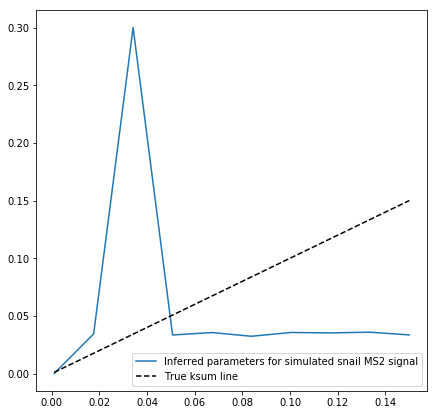

In [79]:
# Now plot the inferred parameters against the true inputs
fig,ax = plt.subplots(1, 1, figsize=(7,7), sharex=True)

ax.plot(ksum_true, np.asarray(ksum_fit_list), label='Inferred parameters for simulated snail MS2 signal')
ax.plot(ksum_true, ksum_true, '--', color='k', label='True ksum line')
#ax.set_xlim(0,0.15)
#ax.set_ylim(0,0.15)
plt.legend(loc='best')
plt.show()
#for i in autolist[1:]:

In [81]:
# do a bootstrap to find deviational ellipse in kon, koff to see how spread we are

# define all needed parameters for simulation and fitting #
stepsize = 3.8            # time between observations, seconds
tPol=4;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

kon_true = 0.002
koff_true = 0.013

duration = 435   # seconds
num = 100           # number of traces in each simulated dataset
loop_function = SnailPromoterMs2Loops().loop_function


In [ ]:
ntrials = 1000
konfit = []
kofffit = []
chartimefit = []
for k in range((ntrials)):
    
    # simulated trace package
    tracePackage = tracePackageSimulation(num, kon_true, koff_true, duration, stepsize, loop_function, k_elong, tPol)
    # compute autocorrelation attributes
    autopackage = tracePackageAutocorrelation(tracePackage.tracelist, loop_function, start_index, stop_index)
    # create the fitting object
    fitAutoPack = fitAutocorrelationFunction(autopackage, tPol, k_elong, stepsize)
    # fit function with a constant pon and store pars
    kon_fit,koff_fit,chrtime,pon,popt,pcov = fitAutoPack.leastSquaresAutoFit(printvals=False, 
                                                                                   upperbound=0.3, lowerbound=0.0005, fitpon=False, pon=pon)

    konfit.append(kon_fit)
    kofffit.append(koff_fit)    
    chartimefit.append(1/chrtime)

In [ ]:
# Now plot the inferred parameters against the true inputs
fig,ax = plt.subplots(1, 1, figsize=(7,7), sharex=True)

ax.plot(konfit, kofffit, marker='.', color='b', alpha=0.3, label = "Fitted Points")
ax.plot(kon_true, koff_true, marker='+', color='r', zorder=10, label = "True parameters")

ax.set_xlabel('$k_on$ $s^{-1}$')
ax.set_ylabel('$k_off$ $s^{-1}$')

plt.legend(loc='best')
plt.show()